In [1]:
import yolo3_one_file_to_detect_them_all as yolo
from tensorflow.keras.models import load_model
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

Using TensorFlow backend.


# Build model

A https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/ oldalon találtak alapján:

Tanított súlyok letöltése.

Szükséges függvények átemelése innen: https://raw.githubusercontent.com/experiencor/keras-yolo3/master/yolo3_one_file_to_detect_them_all.py

Model készítése a súlyokkal.

Végeredmény egy horodzható .h5 file, továbbiakban csak ezzel kell dolgozni (de 237MB)

In [2]:
model = yolo.make_yolov3_model()
weight_reader = yolo.WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

# Functions

In [3]:
def load_image_pixels(filename, shape = (416,416)):
    """ kép + modell számára elvárt méret -> előfeldolgozott kép + eredeti méret """
    
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    return image, width, height

In [4]:
def get_boxes(boxes, labels, thresh):
    """ Minden dobozra minden címkét letesztel, egy dobozra akár többet is """
    
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)

    return v_boxes, v_labels, v_scores

In [5]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    """ képre kirajzolja a dobozokat, kiírja az osztályt és a pontot is"""
    
    data = pyplot.imread(filename)
    pyplot.imshow(data)

    ax = pyplot.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]

        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')

        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')

    pyplot.show()

In [6]:
def Detect(photo_filename, input_w = 416, input_h = 416, class_threshold = 0.6, labels = ["person"], anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]):
    """ 
        Bemeneti parméterek:
            input_w/h: modell elvárt bemeneti mérete
            class_treshold: ennyi konfidencia felett tartjuk meg a jelölt osztályokat
            labels: ezeket ismeri fel (be lehet rakni csomó mindent, fun)
            anchors: valahogy ezek alapján képzi le a BB-ket
                     nem tudom az anchort hogy kell módosítani, azt hittem a YOLO pont azt tudja, hogy ezzel nem kell szívni már
    
        Feldolgozás lépései:
            1. Kép betöltése, előfeldolgozása
            2. Modell futtatása
            3. BoundigBox-ok előállítása 
            4. BB méret korrekció 
            5. átfedések kezelése
            4. BB címkézése
            
        Kimenet:
            boxes: befoglaló doboz
            labels: predikált osztály (nálunk ugye ez mindig person lesz, ezért kivehető akár)
            scores: ~konfidencia
    """
    image, image_w, image_h = load_image_pixels(photo_filename,(input_w, input_h))
    
    yhat = model.predict(image)
        
    boxes = list()
    for i in range(len(yhat)):
        boxes += yolo.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
        
    yolo.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    
    yolo.do_nms(boxes, 0.5)
    
    boxes, labels, scores = get_boxes(boxes, labels, class_threshold)
    
    return boxes, labels, scores

# Playground

W1014 16:36:34.686641 25660 hdf5_format.py:187] No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


person 84.48694944381714
person 99.57067966461182
person 98.79075288772583
person 98.31680059432983
person 96.2040364742279
person 62.55853772163391
person 91.73893928527832
person 99.58672523498535
person 99.46344494819641


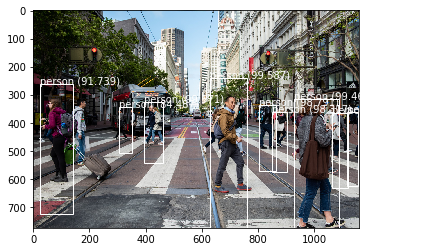

In [8]:
model = load_model('model.h5')
filename = 'input.jpg'
v_boxes, v_labels, v_scores = Detect(filename)
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
draw_boxes(filename, v_boxes, v_labels, v_scores)